In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import ast

from geopy.distance import geodesic

from PIL import Image
from io import BytesIO

In [ ]:
with open('data/api_keys.json', 'r') as file:
    keys = json.load(file)

maps_api_key = keys['Google']
geonames_username = keys['Geonames']

# API Queries

In [3]:
coords = (40.760113, -73.87768)
url = f"http://api.geonames.org/findNearestIntersectionJSON?lat={coords[0]}&lng={coords[1]}&username={geonames_username}"
response = requests.get(url)
response.status_code
response.json()

{'credits': '1.0',
 'intersection': {'mtfcc1': 'S1400',
  'mtfcc2': 'S1400',
  'adminCode1': 'NY',
  'lng': '-73.877668',
  'distance': '0',
  'bearing': '83',
  'placename': 'New York',
  'street1Bearing': '81',
  'street2Bearing': '172',
  'adminName2': 'Queens',
  'postalcode': '11369',
  'countryCode': 'US',
  'street1': '31st Ave',
  'street2': '91st St',
  'adminName1': 'New York',
  'lat': '40.760114'}}

In [4]:
coords = (40.68535233392957, -73.99143437311176)
url = f"https://roads.googleapis.com/v1/nearestRoads?points={coords[0]},{coords[1]}&key={maps_api_key}"
nearby_response = requests.get(url)
nearby_response.status_code
print(nearby_response.json())

for i in range(len(nearby_response.json()['snappedPoints'])):
    id = nearby_response.json()['snappedPoints'][i]['placeId']
    url = f"https://maps.googleapis.com/maps/api/geocode/json?place_id={id}&key={maps_api_key}"
    response = requests.get(url)
    response.status_code
    print(response.json())

{'snappedPoints': [{'location': {'latitude': 40.68534321944763, 'longitude': -73.99141075224523}, 'originalIndex': 0, 'placeId': 'ChIJvyu4rVFawokRP5tdYIO-iTs'}]}
{'results': [{'address_components': [{'long_name': '195-189', 'short_name': '195-189', 'types': ['street_number']}, {'long_name': 'Smith Street', 'short_name': 'Smith St', 'types': ['route']}, {'long_name': 'Boerum Hill', 'short_name': 'Boerum Hill', 'types': ['neighborhood', 'political']}, {'long_name': 'Brooklyn', 'short_name': 'Brooklyn', 'types': ['political', 'sublocality', 'sublocality_level_1']}, {'long_name': 'Kings County', 'short_name': 'Kings County', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'New York', 'short_name': 'NY', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'United States', 'short_name': 'US', 'types': ['country', 'political']}, {'long_name': '11201', 'short_name': '11201', 'types': ['postal_code']}, {'long_name': '6410', 'short_name': '6410', 'types': 

# Intersection Flags

In [ ]:
int_flags = pd.read_csv('data/reference/intersection_flags_all.csv') # 'data/reference/intersection_flags_pedcyc_10.04.csv')
print(
    f'Non-NA: {len(int_flags[~pd.isna(int_flags.data)])}\n'
    f'NA: {len(int_flags[pd.isna(int_flags.data)])}\n'
)
print(int_flags.intersection.value_counts())
display(int_flags)

Non-NA: 266285
NA: 4652

intersection
False    152068
True     118869
Name: count, dtype: int64


lat        lng  intersection  \
0       40.662780 -73.880860          True   
1       40.660217 -73.896750          True   
2       40.620487 -74.029305          True   
3       40.885784 -73.848270          True   
4       40.736797 -73.887400          True   
...           ...        ...           ...   
270932  40.870810 -73.846910          True   
270933  40.612492 -73.897060         False   
270934  40.728485 -73.872480         False   
270935  40.725350 -73.793100          True   
270936  40.682552 -73.858734          True   

                                                     data  
0       {'mtfcc1': 'S1400', 'mtfcc2': 'S1200', 'adminC...  
1       {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
2       {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
3       {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
4       {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
...                                                   ...  
270932  {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
270933                                                NaN  
270934  {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
270935  {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  
270936  {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  

[270937 rows x 4 columns]

In [6]:
int_flags_nona = int_flags.dropna(subset=['data']).reset_index(drop=True)
int_flags = pd.DataFrame()

# Loop through each row, parse data and add to dataframe
for i in range(len(int_flags_nona)):
    row = pd.Series(int_flags_nona.iloc[i])
    add_on = pd.DataFrame.from_dict(ast.literal_eval(int_flags_nona.data[i]), orient='index')
    new_row = pd.concat([row, add_on], axis=0, ignore_index=True).T
    int_flags = pd.concat([int_flags, new_row], axis=0)

int_flags

0          1      2   \
0    40.66278  -73.88086   True   
0   40.660217  -73.89675   True   
0   40.620487 -74.029305   True   
0   40.885784  -73.84827   True   
0   40.736797   -73.8874   True   
..        ...        ...    ...   
0   40.608334  -73.98363  False   
0    40.87081  -73.84691   True   
0   40.728485  -73.87248  False   
0    40.72535   -73.7931   True   
0   40.682552 -73.858734   True   

                                                   3      4      5   6   \
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1200', 'adminC...  S1400  S1200  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
..                                                ...    ...    ...  ..   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   
0   {'mtfcc1': 'S1400', 'mtfcc2': 'S1400', 'adminC...  S1400  S1400  NY   

            7     8    9         10   11   12      13     14  15  \
0   -73.880892  0.01  335  New York  150   59   Kings         US   
0    -73.89674     0   89  New York   59  169   Kings  11207  US   
0   -74.029303     0  175  New York  197  120   Kings  11209  US   
0   -73.848364  0.02  202  New York   26  112   Bronx  10466  US   
0   -73.887535  0.01  251  New York   76  185  Queens  11373  US   
..         ...   ...  ...       ...  ...  ...     ...    ...  ..   
0   -73.983477  0.08  170  New York  171   81   Kings  11204  US   
0   -73.846992  0.01  304  New York  124    1   Bronx  10469  US   
0   -73.873242  0.09  225  New York   45  136  Queens  11374  US   
0   -73.793335  0.02  249  New York   67  171  Queens  11366  US   
0   -73.858727     0   79  New York   69  159  Queens  11416  US   

               16            17        18         19  
0      Ashford St   Linden Blvd  New York  40.662834  
0    New Lots Ave  Williams Ave  New York  40.660217  
0         4th Ave       89th St  New York  40.620467  
0     Laconia Ave    E 227th St  New York   40.88561  
0        51st Ave    Jacobus St  New York  40.736763  
..            ...           ...       ...        ...  
0       W 10th St         Ave P  New York  40.607663  
0   E Gun Hill Rd      Fish Ave  New York  40.870853  
0       Eliot Ave       85th St  New York  40.727912  
0      Union Tpke      176th St  New York  40.725284  
0        97th Ave       81st St  New York  40.682553  

[266285 rows x 20 columns]

In [7]:
# Provide the correct column names
original_cols = int_flags_nona.columns.to_list()
new_cols = pd.DataFrame.from_dict(ast.literal_eval(int_flags_nona.data[0]), orient='index').T.columns.to_list()
new_cols = [x + '_int' if x in ['lat', 'lng'] else x for x in new_cols]
int_flags.columns = original_cols+new_cols
# Reorder columns
new_col_order = original_cols + ['lat_int', 'lng_int'] + [x for x in new_cols if x not in ['lat_int', 'lng_int']]
int_flags = int_flags[new_col_order]
# Drop data column and print
int_flags = int_flags.drop('data', axis=1).reset_index(drop=True)
int_flags

lat        lng intersection    lat_int     lng_int mtfcc1  \
0        40.66278  -73.88086         True  40.662834  -73.880892  S1400   
1       40.660217  -73.89675         True  40.660217   -73.89674  S1400   
2       40.620487 -74.029305         True  40.620467  -74.029303  S1400   
3       40.885784  -73.84827         True   40.88561  -73.848364  S1400   
4       40.736797   -73.8874         True  40.736763  -73.887535  S1400   
...           ...        ...          ...        ...         ...    ...   
266280  40.608334  -73.98363        False  40.607663  -73.983477  S1400   
266281   40.87081  -73.84691         True  40.870853  -73.846992  S1400   
266282  40.728485  -73.87248        False  40.727912  -73.873242  S1400   
266283   40.72535   -73.7931         True  40.725284  -73.793335  S1400   
266284  40.682552 -73.858734         True  40.682553  -73.858727  S1400   

       mtfcc2 adminCode1 distance bearing placename street1Bearing  \
0       S1200         NY     0.01     335  New York            150   
1       S1400         NY        0      89  New York             59   
2       S1400         NY        0     175  New York            197   
3       S1400         NY     0.02     202  New York             26   
4       S1400         NY     0.01     251  New York             76   
...       ...        ...      ...     ...       ...            ...   
266280  S1400         NY     0.08     170  New York            171   
266281  S1400         NY     0.01     304  New York            124   
266282  S1400         NY     0.09     225  New York             45   
266283  S1400         NY     0.02     249  New York             67   
266284  S1400         NY        0      79  New York             69   

       street2Bearing adminName2 postalcode countryCode        street1  \
0                  59      Kings                     US     Ashford St   
1                 169      Kings      11207          US   New Lots Ave   
2                 120      Kings      11209          US        4th Ave   
3                 112      Bronx      10466          US    Laconia Ave   
4                 185     Queens      11373          US       51st Ave   
...               ...        ...        ...         ...            ...   
266280             81      Kings      11204          US      W 10th St   
266281              1      Bronx      10469          US  E Gun Hill Rd   
266282            136     Queens      11374          US      Eliot Ave   
266283            171     Queens      11366          US     Union Tpke   
266284            159     Queens      11416          US       97th Ave   

             street2 adminName1  
0        Linden Blvd   New York  
1       Williams Ave   New York  
2            89th St   New York  
3         E 227th St   New York  
4         Jacobus St   New York  
...              ...        ...  
266280         Ave P   New York  
266281      Fish Ave   New York  
266282       85th St   New York  
266283      176th St   New York  
266284       81st St   New York  

[266285 rows x 19 columns]

Max distance: 0.7201125208245265


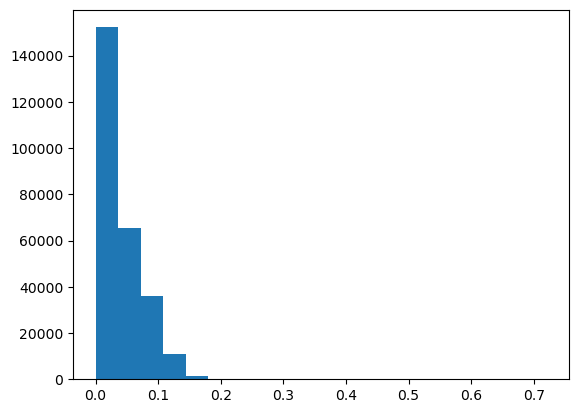

In [8]:
int_flags['distance_site_int'] = int_flags.apply(lambda row: geodesic((row.lat, row.lng), (row.lat_int, row.lng_int)).km, axis=1)
print(f'Max distance: {int_flags.distance_site_int.max()}')
plt.figure()
plt.hist(int_flags.distance_site_int, bins=20)
plt.show()

In [9]:
int_flags = int_flags[int_flags.distance_site_int < 0.015].sort_values(by='distance_site_int')

### Duplication

In [10]:
num_decimals = 4
int_flags['dupe_key'] = int_flags.apply(lambda row: f'{round(row.lat, num_decimals)}_{round(row.lng, num_decimals)}', axis=1)
int_flags.drop_duplicates(subset=['dupe_key'], keep=False)

lat        lng intersection    lat_int     lng_int mtfcc1  \
3336    40.811651 -73.914474         True  40.811651  -73.914474  S1400   
78163   40.733204   -74.0098         True  40.733204    -74.0098  S1400   
98569      40.718  -73.82546         True     40.718   -73.82546  S1400   
197686  40.590126  -74.09358         True  40.590126   -74.09358  S1400   
8944    40.609684  -73.98576         True  40.609684   -73.98576  S1400   
...           ...        ...          ...        ...         ...    ...   
167941   40.66392   -73.9427         True  40.664055  -73.942696  S1400   
1211    40.712776  -73.90601         True  40.712646  -73.905962  S1400   
174101  40.710117  -73.81025         True  40.710252  -73.810246  S1400   
130145   40.65172 -73.946754         True  40.651854  -73.946776  S1400   
232277   40.64669  -74.00869         True  40.646788  -74.008568  S1400   

       mtfcc2 adminCode1 distance bearing  ... street1Bearing street2Bearing  \
3336    S1400         NY        0       0  ...             23            113   
78163   S1400         NY        0       0  ...            259            183   
98569   S1400         NY        0       0  ...            178             82   
197686  S1400         NY        0       0  ...            124            226   
8944    S1400         NY        0       0  ...            218            171   
...       ...        ...      ...     ...  ...            ...            ...   
167941  S1400         NY     0.02       1  ...            184             94   
1211    S1400         NY     0.02     164  ...            161             37   
174101  S1400         NY     0.02       1  ...            174             71   
130145  S1400         NY     0.02     352  ...            175             85   
232277  S1400         NY     0.01      43  ...            218            128   

       adminName2 postalcode countryCode         street1       street2  \
3336        Bronx      10454          US  Saint Anns Ave    E 145th St   
78163    New York      10014          US       W 10th St  Weehawken St   
98569      Queens      11367          US       Park Dr E       78th Dr   
197686   Richmond      10305          US       Alter Ave    Hancock St   
8944        Kings      11204          US        Bay Pkwy     W 12th St   
...           ...        ...         ...             ...           ...   
167941      Kings      11225          US    Kingston Ave   Empire Blvd   
1211       Queens      11385          US      Forest Ave     Harman St   
174101     Queens      11435          US        148th St       85th Rd   
130145      Kings      11203          US    New York Ave   Martense St   
232277      Kings      11220          US         5th Ave       47th St   

       adminName1 distance_site_int          dupe_key  
3336     New York          0.000000  40.8117_-73.9145  
78163    New York          0.000000  40.7332_-74.0098  
98569    New York          0.000000   40.718_-73.8255  
197686   New York          0.000000  40.5901_-74.0936  
8944     New York          0.000000  40.6097_-73.9858  
...           ...               ...               ...  
167941   New York          0.014995  40.6639_-73.9427  
1211     New York          0.014995   40.7128_-73.906  
174101   New York          0.014995  40.7101_-73.8102  
130145   New York          0.014996  40.6517_-73.9468  
232277   New York          0.014997  40.6467_-74.0087  

[33725 rows x 21 columns]

In [11]:
num_decimals = 10
int_flags.lat_int = int_flags.lat_int.astype(float)
int_flags.lng_int = int_flags.lng_int.astype(float)
int_flags['dupe_key'] = int_flags.apply(lambda row: f'{round(row.lat_int, num_decimals)}_{round(row.lng_int, num_decimals)}', axis=1)
int_flags.drop_duplicates(subset=['dupe_key'], keep=False)

lat       lng intersection    lat_int    lng_int mtfcc1 mtfcc2  \
197686  40.590126 -74.09358         True  40.590126 -74.093580  S1400  S1400   
12912   40.606354 -74.06043         True  40.606354 -74.060430  S1400  S1400   
55012   40.637337 -74.00047         True  40.637337 -74.000470  S1400  S1400   
81610   40.529484 -74.15801         True  40.529484 -74.158010  S1400  S1400   
197950  40.608513 -74.12502         True  40.608513 -74.125020  S1400  S1400   
...           ...       ...          ...        ...        ...    ...    ...   
27117   40.852615 -73.90351         True  40.852495 -73.903591  S1400  S1400   
211502  40.590115 -73.99061         True  40.590180 -73.990455  S1400  S1400   
77604   40.657257 -73.89791         True  40.657391 -73.897930  S1400  S1400   
78311   40.701256 -74.01432         True  40.701248 -74.014143  S1100  S1400   
104407  40.838932 -73.91364         True  40.838810 -73.913716  S1400  S1400   

       adminCode1 distance bearing  ... street1Bearing street2Bearing  \
197686         NY        0       0  ...            124            226   
12912          NY        0       0  ...            153            150   
55012          NY        0       0  ...            128            218   
81610          NY        0       0  ...             25            232   
197950         NY        0       0  ...            256            176   
...           ...      ...     ...  ...            ...            ...   
27117          NY     0.01     207  ...            120             32   
211502         NY     0.01      61  ...            224            143   
77604          NY     0.01     353  ...            169             80   
78311          NY     0.01      93  ...            115            285   
104407         NY     0.01     205  ...            115             23   

       adminName2 postalcode countryCode               street1  \
197686   Richmond      10305          US             Alter Ave   
12912    Richmond      10305          US          New York Ave   
55012       Kings      11219          US               52nd St   
81610    Richmond      10312          US    Mayberry Promenade   
197950   Richmond      10314          US          Gannon Ave S   
...           ...        ...         ...                   ...   
27117       Bronx                     US        E Burnside Ave   
211502      Kings      11214          US           Bay 43rd St   
77604       Kings      11207          US          Snediker Ave   
78311    New York                     US  Battery Park Viaduct   
104407      Bronx                     US            E 170th St   

                street2 adminName1 distance_site_int              dupe_key  
197686       Hancock St   New York          0.000000   40.590126_-74.09358  
12912            Bay St   New York          0.000000   40.606354_-74.06043  
55012          10th Ave   New York          0.000000   40.637337_-74.00047  
81610      Wakefield Rd   New York          0.000000   40.529484_-74.15801  
197950         Melba St   New York          0.000000   40.608513_-74.12502  
...                 ...        ...               ...                   ...  
27117   Grand Concourse   New York          0.014975  40.852495_-73.903591  
211502          Mill Rd   New York          0.014976   40.59018_-73.990455  
77604       Linden Blvd   New York          0.014976   40.657391_-73.89793  
78311          State St   New York          0.014985  40.701248_-74.014143  
104407  Grand Concourse   New York          0.014988   40.83881_-73.913716  

[11364 rows x 21 columns]

In [29]:
int_flags_deduped = int_flags.drop_duplicates(subset=['dupe_key'], keep='first')
int_flags_deduped.shape

(39162, 21)

In [ ]:
int_flags_deduped.to_csv('data/reference/int_flags_deduped.csv', index=False)
int_flags[['lat', 'lng', 'lat_int', 'lng_int', 'dupe_key']].to_csv('data/reference/site_int_dict.csv', index=False)

# Sample Images

In [4]:
def get_satellite_image(lat, lon, zoom=20, size="640x640", map_type="satellite", api_key=maps_api_key):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": f"{lat},{lon}",
        "zoom": zoom,
        "size": size,
        "maptype": map_type,
        "key": api_key
    }
    response = requests.get(base_url, params=params)
    image = Image.open(BytesIO(response.content))
    return image

In [15]:
int_flags[int_flags.duplicated(subset=['dupe_key'], keep=False)].sort_values(by='dupe_key').head(30)

lat        lng intersection    lat_int    lng_int mtfcc1 mtfcc2  \
189705    40.5018  -74.24348         True  40.501799 -74.243474  S1400  S1400   
222343    40.5018 -74.243473         True  40.501799 -74.243474  S1400  S1400   
210428  40.502775  -74.25183         True  40.502774 -74.251830  S1400  S1400   
102104  40.502773  -74.25184         True  40.502774 -74.251830  S1400  S1400   
104348  40.502804  -74.25186         True  40.502774 -74.251830  S1400  S1400   
239322  40.503746  -74.24706         True  40.503757 -74.247023  S1400  S1400   
182454  40.503757  -74.24703         True  40.503757 -74.247023  S1400  S1400   
180514   40.50394   -74.2461         True  40.503940 -74.246090  S1400  S1400   
240872  40.503941 -74.246091         True  40.503940 -74.246090  S1400  S1400   
146109   40.50429 -74.244331         True  40.504291 -74.244329  S1400  S1400   
123979   40.50429  -74.24434         True  40.504291 -74.244329  S1400  S1400   
189034   40.50447 -74.243454         True  40.504469 -74.243450  S1400  S1400   
142710  40.504471  -74.24345         True  40.504469 -74.243450  S1400  S1400   
27340   40.504831 -74.241639         True  40.504832 -74.241639  S1400  S1400   
61877    40.50483 -74.241646         True  40.504832 -74.241639  S1400  S1400   
141890  40.505012 -74.240734         True  40.505013 -74.240733  S1400  S1400   
23755   40.505013  -74.24074         True  40.505013 -74.240733  S1400  S1400   
83356   40.505195  -74.23981         True  40.505193 -74.239810  S1400  S1400   
122499  40.505196 -74.239815         True  40.505193 -74.239810  S1400  S1400   
44696   40.505527 -74.238175         True  40.505527 -74.238181  S1400  S1400   
104933  40.505447 -74.238174         True  40.505527 -74.238181  S1400  S1400   
5541    40.505527  -74.23818         True  40.505527 -74.238181  S1400  S1400   
124757  40.505527  -74.23819         True  40.505527 -74.238181  S1400  S1400   
259020  40.506188 -74.234894         True  40.506189 -74.234896  S1400  S1400   
37903   40.506187   -74.2349         True  40.506189 -74.234896  S1400  S1400   
160796   40.50648  -74.24697         True  40.506480 -74.246965  S1400  S1400   
96713   40.506481 -74.246964         True  40.506480 -74.246965  S1400  S1400   
190284  40.506757 -74.233063         True  40.506756 -74.233063  S1400  S1400   
16011   40.506756  -74.23307         True  40.506756 -74.233063  S1400  S1400   
84411   40.507626 -74.252876         True  40.507625 -74.252878  S1400  S1400   

       adminCode1 distance bearing  ... street1Bearing street2Bearing  \
189705         NY        0     102  ...            255            165   
222343         NY        0     223  ...            255            165   
210428         NY        0     192  ...            153            253   
102104         NY        0      82  ...            150            253   
104348         NY        0     142  ...            153            253   
239322         NY        0      68  ...            254            165   
182454         NY        0      89  ...            254            165   
180514         NY        0      89  ...            255            165   
240872         NY        0     123  ...            165            255   
146109         NY        0      61  ...            255            165   
123979         NY        0      83  ...            255            165   
189034         NY        0     108  ...            255            165   
142710         NY        0     171  ...            165            255   
27340          NY        0      18  ...            165            255   
61877          NY        0      69  ...            255            165   
141890         NY        0      23  ...            165            255   
23755          NY        0      89  ...            255            165   
83356          NY        0     172  ...            254            165   
122499         NY        0     128  ...            255            165   
44696          NY        0     263  ...   

Stree1 Amboy Rd -- Street2: Station Ave


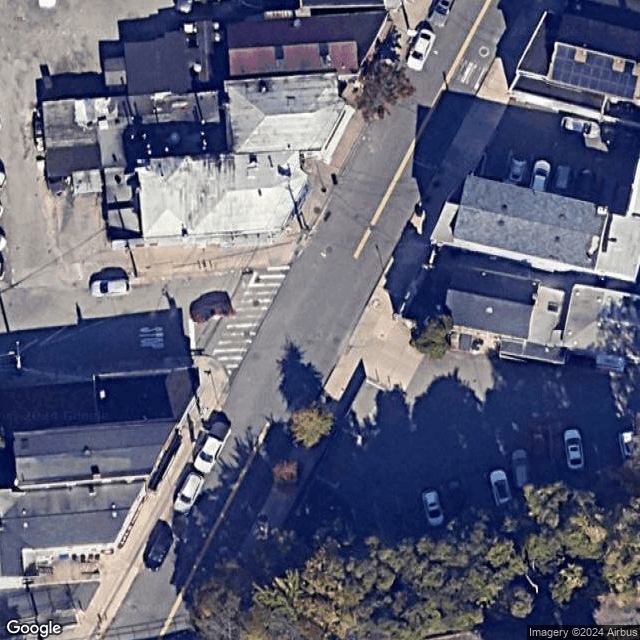

In [16]:
record = int_flags.loc[2435]
print(f'Stree1 {record.street1} -- Street2: {record.street2}')
img = get_satellite_image(record.lat, record.lng)
display(img)

In [17]:
int_flags_deduped.adminName2.value_counts()

adminName2
Queens         5076
Richmond       2738
Kings          1734
Bronx          1377
New York        423
Nassau            9
Westchester       7
Name: count, dtype: int64

Elmwood Ave and E 4th St -- Kings


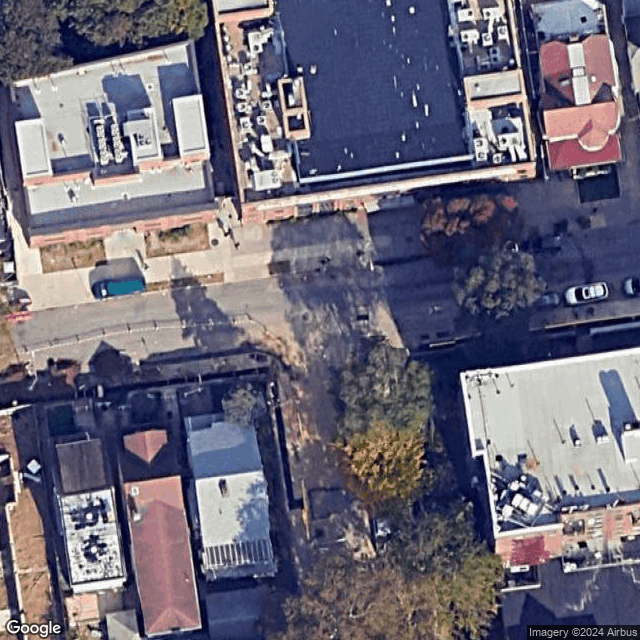

57th Ave and Hewlett St -- Queens


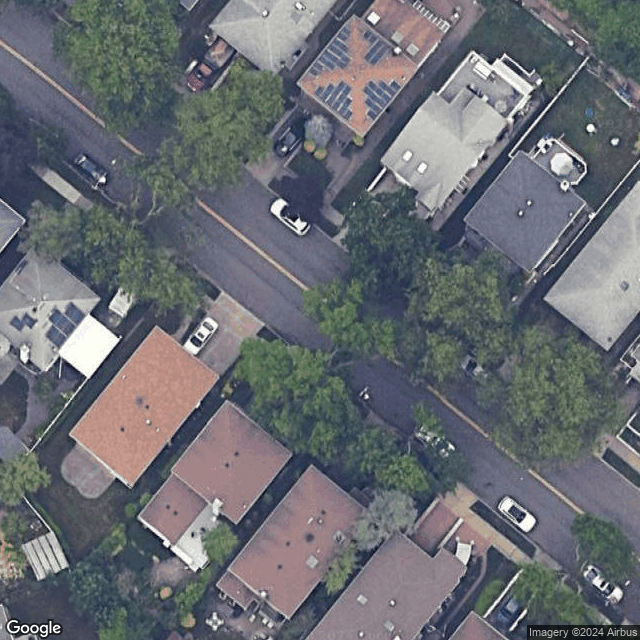

Locust Ave and E 132nd St -- Bronx


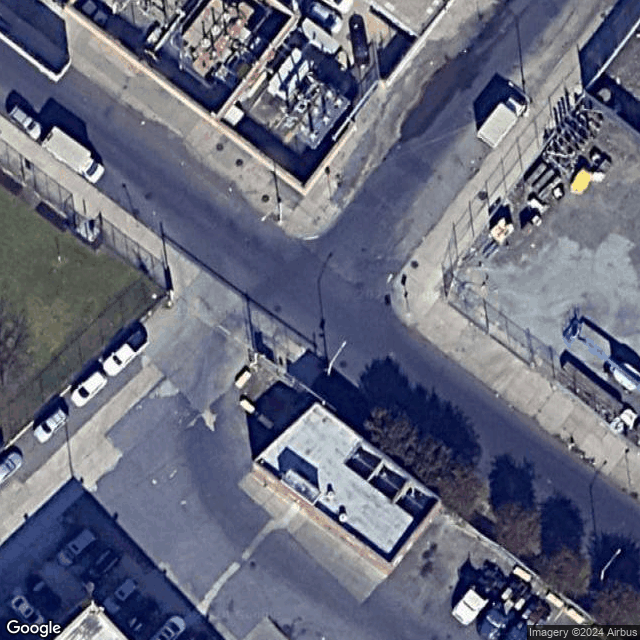

84th Dr and Queens Blvd -- Queens


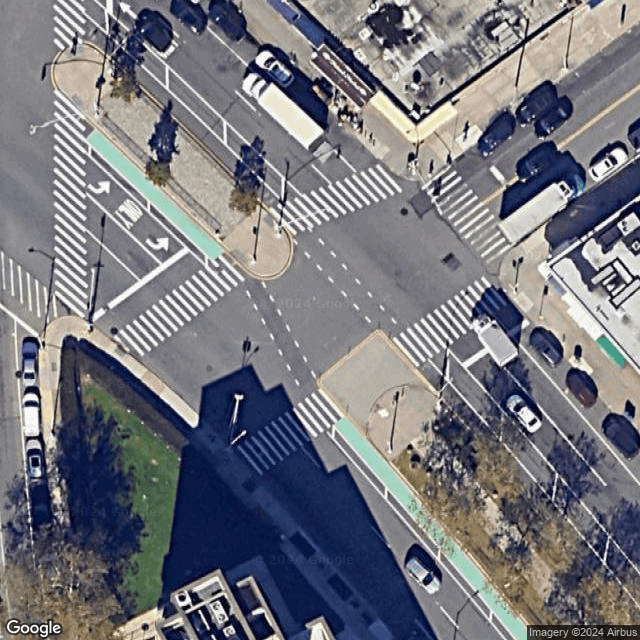

58th Ave and Brown Pl -- Queens


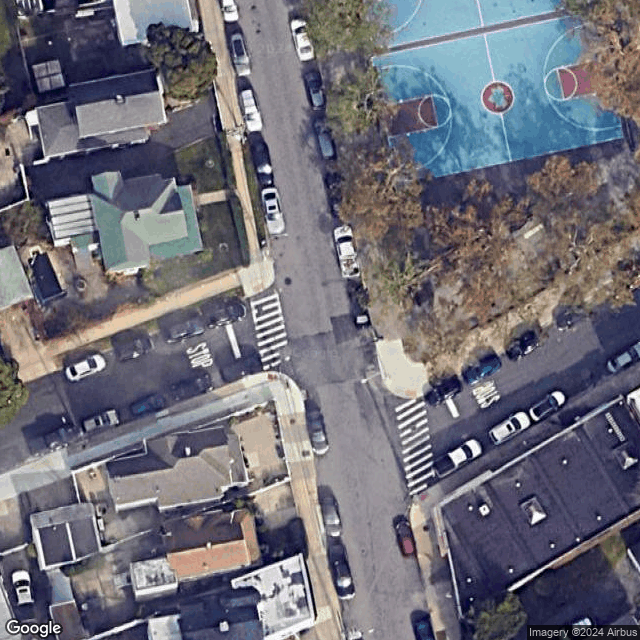

Ocean Promenade and Beach 124th St -- Queens


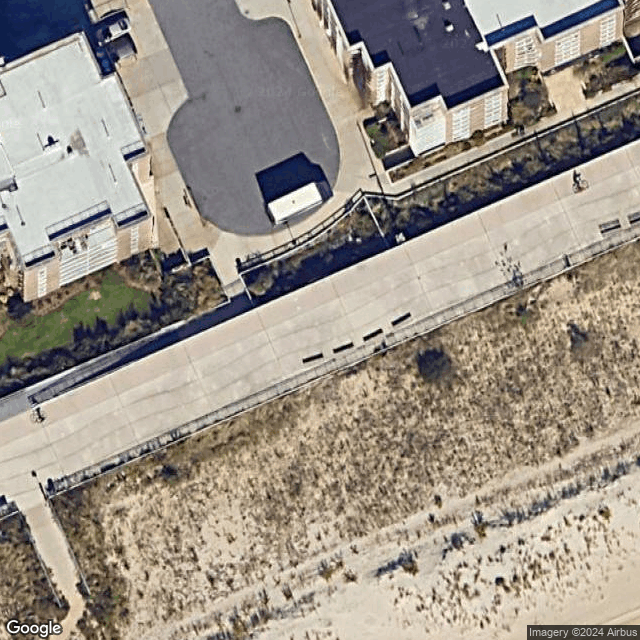

Ave R and E 10th St -- Kings


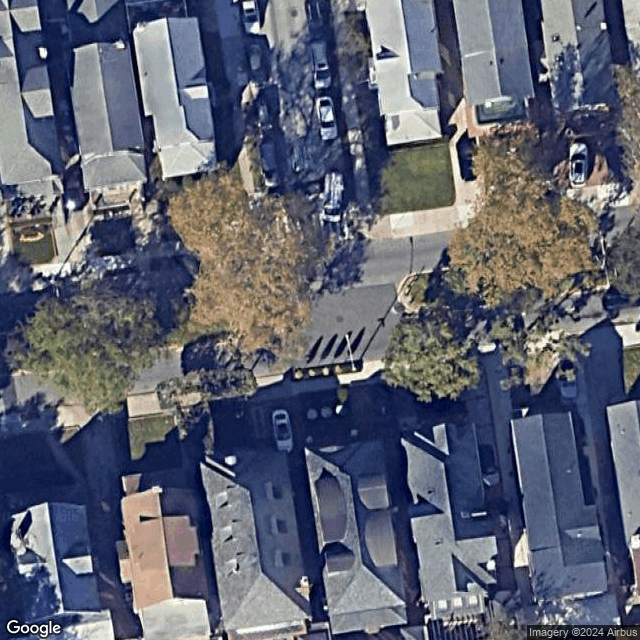

Dixon Ave and Pulaski Ave -- Richmond


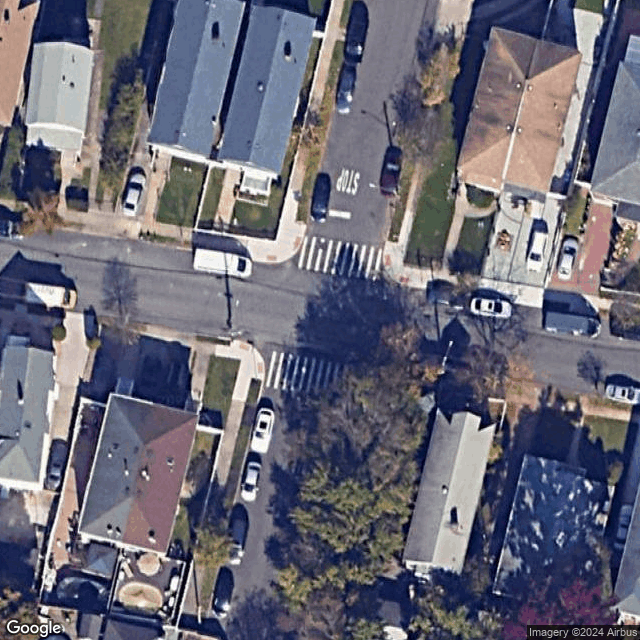

5th Ave and 147th Pl -- Queens


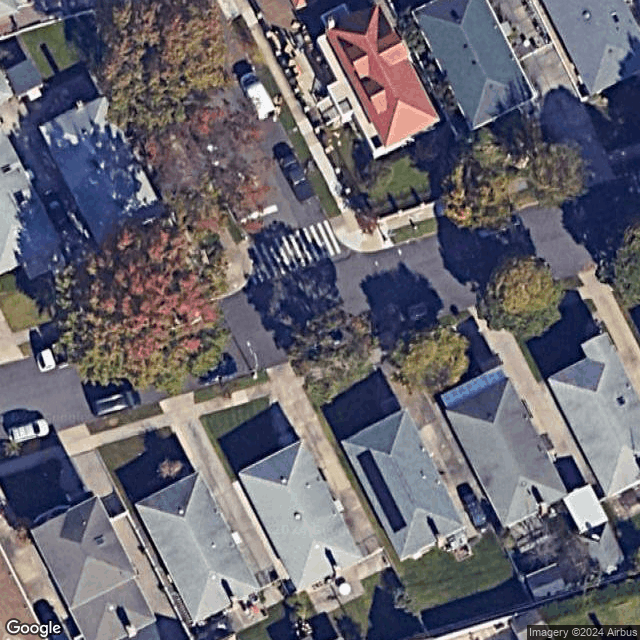

11th St and 45th Rd -- Queens


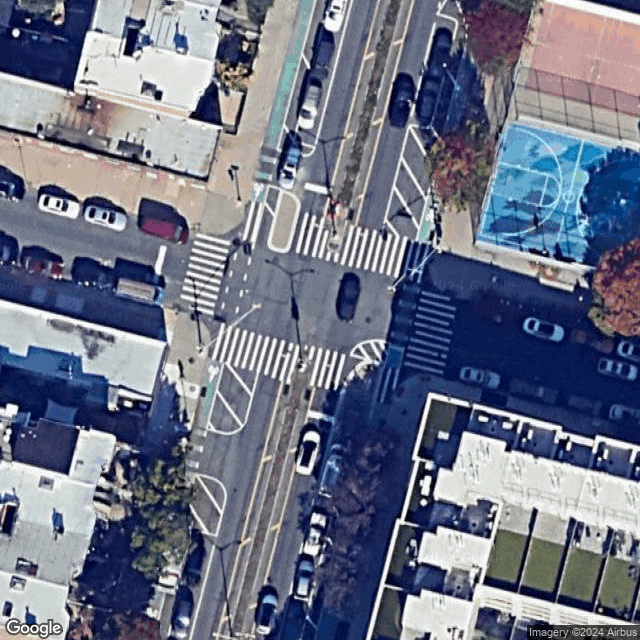

In [ ]:
for i in np.random.randint(0, int_flags_deduped.shape[0], 10):
    record = int_flags_deduped.iloc[i]
    print(f'{record.street1} and {record.street2} -- {record.adminName2}')
    img = get_satellite_image(record.lat, record.lng, size="1280x1280")
    display(img)

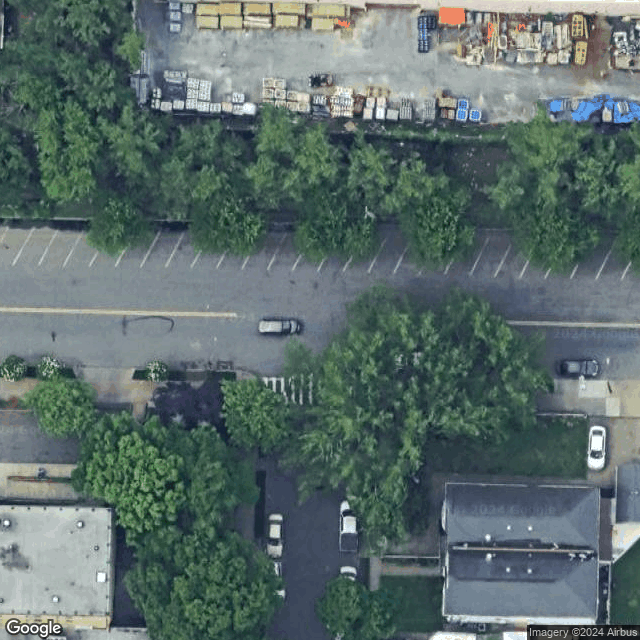

In [6]:
get_satellite_image(40.8607, -73.833364, size="1280x1280")